(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Clustering food recipes from around the world

In this assignment, you are expected to hierarchically cluster food recipes. We will be using YY Ahn's dataset "[Recipe datasets with cuisines](http://yongyeol.com/data/scirep-cuisines-detail.zip)", which for each recipe provides a list of ingredients and the country of origin, scraped from popular recipe websites. He also provides an [ingredient and compounds dataset](http://yongyeol.com/data/ingr_comp.zip), which you could potentially also make use of, if you find it interesting.

You will be graded as follow:
* Data parsing and representation **(20 pts)**
* Clustering **(30 pts)**
* Visualization **(30 pts)**
* Short (detailed) analysis of specific cluster **(20 pts)**

---------------------------

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
from gensim import corpora, models, similarities


Start by reading the data for mapping food types to regions.

In [5]:
food_map = pd.read_csv('map.txt', header=None,
                         delimiter='\t', names=['food_type', 'region'])
food_map.region.value_counts(dropna=False)

WesternEuropean     12
EastAsian            9
SouthernEuropean     8
SoutheastAsian       7
LatinAmerican        6
MiddleEastern        6
African              6
NorthAmerican        5
SouthAsian           4
EasternEuropean      2
NorthernEuropean     2
NaN                  2
dtype: int64

By checking for abnormalities in our data, we can see that there are two lines for which we have no region information (their value is *NaN*). Checking the raw data (the corresponding rows), we see that both these records correspond to asian food. We go ahead and correct this accordingly.

In [6]:
food_map.region[food_map.region.isnull()]

12    NaN
65    NaN
Name: region, dtype: object

In [7]:
food_map.region[food_map.region.isnull()] = 'Asian'
food_map.region.value_counts(dropna=False)

WesternEuropean     12
EastAsian            9
SouthernEuropean     8
SoutheastAsian       7
LatinAmerican        6
MiddleEastern        6
African              6
NorthAmerican        5
SouthAsian           4
EasternEuropean      2
Asian                2
NorthernEuropean     2
NaN                  0
dtype: int64

It turns out we have **12 regions in total**, with one region (*Asian*) being a super-region for many others (e.g., *SouthAsian*, *SoutheastAsian*, *EastAsian*). A better data structure for this information is a *dictionary*, so we will save it as such.

In [8]:
food_map_dict = food_map.set_index(food_map.food_type).region.to_dict()

We also parse the data from the recipes. We will use the recipes from [epicurious](http://www.epicurious.com/).

In [15]:
# Start by making an empty DataFrame object. In it, we intend to save
# the origin of a recipe and a bag-of-words representation of its
# ingredients. We will learn and grow the ingredient list as we read the
# recipe file
epicurious = pd.DataFrame()
filepath = 'epic_recipes.txt'
bag_of_words = corpora.Dictionary()
recipes = []
max_recipe_limit = None # If None, this will take a while!

# Read the recipes once to compute the TF-IDF score for 
# each ingredient. We don't just do bag-of-words, because
# some ingredients (shiitake mushrooms) are more "important"
# in defining a recipe than others (garlic). This is basically
# weighting each ingredient according to their frequency. 
# We start by creating the bag-of-words:

with open(filepath, 'r') as f:
    for line_num, line in enumerate(f):
        splits = line.strip().split('\t')
        ingredient_list = splits[1:]
        bag_of_words.add_documents([ingredient_list])
        recipes.append(bag_of_words.doc2bow(ingredient_list))
        if max_recipe_limit is not None and line_num > max_recipe_limit:
            break
        
# Now we can learn a TF-IDF model on the bag-of-words representation
# that we collected.
tfidf_model = models.TfidfModel(recipes)
    
# And finally, we can iterate through the recipes again, and add
# them to a dataframe in which the columns are all the possible 
# ingredients.
with open(filepath, 'r') as f:
    for line_num, line in enumerate(f):
        splits = line.strip().split('\t')
        food_type = splits[0]
        ingredient_list = splits[1:]
        
        # Make a single-record dataframe for the current recipe by
        # combining the food type and the bag-of-words representation
        # of the ingredient list
        row = {'food_type': food_type}  
#      print row
        for ingr, value in  tfidf_model[bag_of_words.doc2bow(ingredient_list)]:
            row[bag_of_words[ingr]] = value
        recipe = pd.DataFrame(row, index=[0])
        
        epicurious = epicurious.append(recipe,
                                       ignore_index=True)
        if max_recipe_limit is not None and line_num > max_recipe_limit:
            break

        
# NaN values mean that an ingredient was not used for this recipe.
# We substitute them with 0.
epicurious.fillna(value=0.0, inplace=True)

In [16]:
for ingr, value in  tfidf_model[bag_of_words.doc2bow(ingredient_list)]:
    bag_of_words.doc2bow
    row[bag_of_words[ingr]] = value
    print bag_of_words[ingr], value, ingr


cayenne 0.198932704664 2
cilantro 0.276057873639 3
garlic 0.12333339376 6
onion 0.147422246905 17
lime 0.431054124753 23
scallion 0.261841137939 31
tomato 0.202277016642 39
wheat 0.151690908287 46
cumin 0.288551449024 50
turkey 0.470452612972 75
avocado 0.473699505625 213


We can also add the region that each recipe is originated from based on its food type.

In [17]:
epicurious['region'] = epicurious.food_type.apply(lambda food_type: food_map_dict[food_type])

In total we have:

In [19]:
print "Number of recipes: %d \nNumber of ingredients %d" %(epicurious.shape[0],
                                                           epicurious.shape[1]-2)

Number of recipes: 13408 
Number of ingredients 350


Now, we should have created a DataFrame with as many rows as the recipes, and as many columns as the ingredients (memory-wise, this should be ok since we only have a couple of hundred ingredients. To scale up, we should use other data stractures instead of a DataFrame). Let's write the dataframe to a CSV file.

In [20]:
epicurious.to_csv('epicurious-bag-of-ingredients.csv')

Here's what a recipe looks like (we only include its ingredients):

In [21]:
i = 3400
epicurious.ix[i][epicurious.ix[i]>0]

apple                 0.254557
bartlett_pear        0.4994745
brandy               0.3214683
butter              0.08128186
cane_molasses        0.1758194
cinnamon             0.1837234
corn                 0.1749255
cream                0.1264791
currant              0.3454203
egg                 0.08941897
food_type             American
lard                 0.2559705
lemon_juice          0.1508065
milk                 0.1431564
nutmeg               0.2536871
starch               0.2338071
vanilla              0.1686834
walnut               0.2688025
wheat               0.09335283
region           NorthAmerican
Name: 3400, dtype: object

Of course, we can also group the recipes by their region

In [22]:
grouped_region = epicurious.groupby('region')
print "We have the following groups:"
for grp in grouped_region.groups.keys():
    print '\t', grp

We have the following groups:
	NorthernEuropean
	WesternEuropean
	SouthernEuropean
	SouthAsian
	LatinAmerican
	NorthAmerican
	EasternEuropean
	Asian
	SoutheastAsian
	African
	MiddleEastern
	EastAsian


Since the total number of recipes is very large in order to just hierarchically cluster, we will sample 5 random recipes from each region and perform the clustering on this subset.

In [39]:
sample = []
for name, group in grouped_region:
    random_sample = group.index[np.random.choice(group.shape[0],
                                                 size=min(group.shape[0], 5),
                                                 replace=False).tolist()]
    sample.extend(random_sample)    
print len(sample)

60


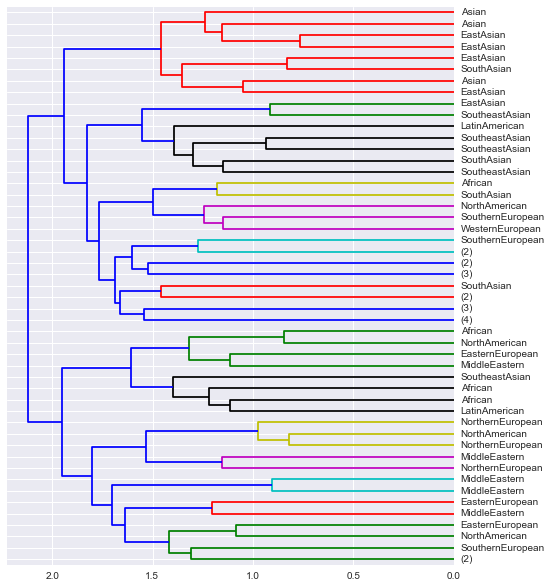

In [31]:
from numpy.random import RandomState
prng = RandomState(1337)
# Sample a small number of recipes
sample = []
for name, group in grouped_region:
    random_sample = group.index[prng.choice(group.shape[0],
                                            size=min(group.shape[0], 5),
                                            replace=False).tolist()]
    sample.extend(random_sample)

# Keep the columns that refer only to ingredients
column_names = set(epicurious.columns.values.tolist())
for name in ['food_type', 'region']:
    column_names.remove(name)
#print column_names
#print sample
numerical = epicurious[list(column_names)].loc[sample]
distance_matrix = squareform(pdist(numerical, metric='cosine'))
fig = plt.subplots(1,1,figsize=(8,10))
Z = linkage(distance_matrix, method='complete')
R = dendrogram(Z,
               labels=epicurious.region.loc[sample].values.tolist(),
               orientation='right',
               truncate_mode='mtica',
               p=6,
               distance_sort='descending')

Although not all of the cluster make sense (remember, we are only working on a very small, and possibly misrepresenting, sample), we can still see some the clusters that make sense, especially if we take into consideration the geographical distance of the regions and the colonial history of some countries.

To compute the distance between the recipes, we used the *cosine similarity*, because we treat the recipe as a collection of words.

Finally, for visualization reasons, we truncate the dendrogram at level 6. Cluster that go deeper than that have a *number* as label, which corresponds to the number of leafs under that particular cluster.

We can repeat the above vizualization, but we can now show the *food type* instead of the region.

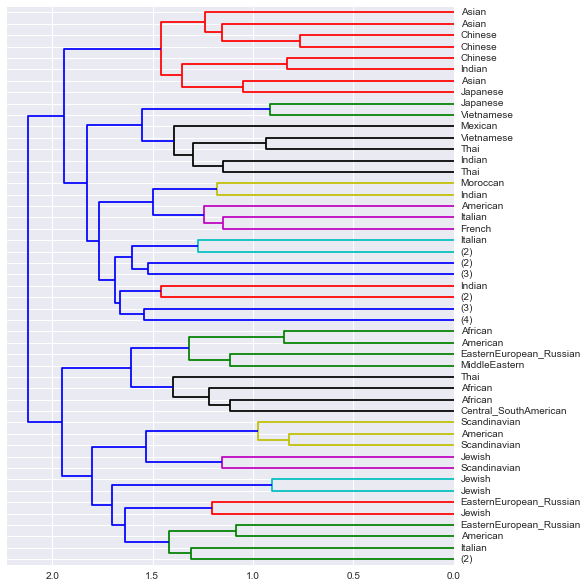

In [14]:
fig = plt.subplots(1,1,figsize=(8,10))
R = dendrogram(Z,
               labels=epicurious.food_type.loc[sample].values.tolist(),
               orientation='right',
               truncate_mode='mtica',
               p=6,
               distance_sort='descending')

----

Until now, we were only checking one recipe at a time (a point of our dataset is a recipe). We can go one step further and group all the recipes of a specific cuisine under the same data point. To do it, and still follow the TF-IDF method, we will need to parse the raw data once more and, for each cusine, create a big string with all the recipes concatenated. 

In [57]:
epicurious_per_cuisine = pd.DataFrame()
filepath = 'epic_recipes.txt'
bag_of_words = corpora.Dictionary()
cuisine_corpus = []
max_recipe_limit = None # If None, this will take a while!

cuisine_ingrs = {}
with open(filepath, 'r') as f:
    for line_num, line in enumerate(f):
        splits = line.strip().split('\t')
        cuisine = splits[0]
        ingredient_list = splits[1:]
        
        if cuisine not in cuisine_ingrs:
            cuisine_ingrs[cuisine] = []
        cuisine_ingrs[cuisine].extend(ingredient_list) 
        if max_recipe_limit is not None and line_num > max_recipe_limit:
            break

for cuisine, ingredients in cuisine_ingrs.iteritems():
    bag_of_words.add_documents([ingredients])
    cuisine_corpus.append(bag_of_words.doc2bow(ingredients))    

tfidf_cuisine = models.TfidfModel(cuisine_corpus)

for cuisine, ingredients in cuisine_ingrs.iteritems():
    row = {'cuisine': cuisine}  
    for ingr, value in  tfidf_cuisine[bag_of_words.doc2bow(ingredients)]:
        row[bag_of_words[ingr]] = value
    cuisine_row = pd.DataFrame(row, index=[0])

    epicurious_per_cuisine = epicurious_per_cuisine.append(cuisine_row,
                                                           ignore_index=True)
print cuisine_row
epicurious_per_cuisine.fillna(value=0.0, inplace=True)

      apple   avocado    bacon       bay      bean  beef_broth      beer  \
0  0.022385  0.495374  0.02802  0.005476  0.007008    0.005256  0.021686   

      beet  black_bean  blue_cheese    ...     tomato_juice    turkey  \
0  0.01401    0.310825     0.038423    ...         0.058612  0.076318   

    vanilla  vegetable    walnut  watercress  watermelon  \
0  0.007462   0.021452  0.007462    0.016425    0.052647   

   whole_grain_wheat_flour      wood  zucchini  
0                 0.043372  0.073641   0.02802  

[1 rows x 119 columns]


In [41]:
epicurious_per_cuisine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 25
Columns: 322 entries, almond to zucchini
dtypes: float64(321), object(1)
memory usage: 65.6+ KB


We can print the 5 most important ingredients per cuisine.

In [34]:
top = 5
for i, row in epicurious_per_cuisine.iterrows():
    cols=row.argsort()[::-1]
    print row[cols[0]]
    print row[cols[1:top]]
    print 
    

Vietnamese
thai_pepper    0.5068857
lemongrass      0.411037
soy_sauce      0.3045381
star_anise     0.2649697
Name: 0, dtype: object

Indian
turmeric                  0.5069822
black_mustard_seed_oil    0.4600048
cardamom                  0.3263985
fenugreek                 0.3149808
Name: 1, dtype: object

Spanish_Portuguese
saffron         0.4492348
pimento         0.3572304
cassava         0.3242785
pork_sausage    0.2328827
Name: 2, dtype: object

Jewish
hazelnut      0.2452996
egg_noodle    0.2180441
almond        0.2097803
dill          0.2078256
Name: 3, dtype: object

French
cognac          0.2683761
lavender        0.2628681
tarragon        0.2462223
apple_brandy    0.2251317
Name: 4, dtype: object

Central_SouthAmerican
avocado           0.5956927
cayenne           0.2687068
oregano            0.246615
cheddar_cheese    0.2233848
Name: 5, dtype: object

Cajun_Creole
okra              0.4093266
pork_sausage      0.3428944
tabasco_pepper    0.2732281
crab              0.258754

In [55]:
epicurious_per_cuisine

,almond,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artichoke,asparagus,avocado,...,watermelon,wheat_bread,whiskey,white_bread,whole_grain_wheat_flour,wine,wood,yam,yogurt,zucchini
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.026773,0.000000,0.000000,0.000000,0.000000
1,0.025997,0.000000,0.014774,0.015251,0.000000,0.019498,0.000000,0.000000,0.007387,0.000000,...,0.035867,0.017934,0.000000,0.000000,0.036936,0.004872,0.000000,0.011764,0.240472,0.033407
2,0.142716,0.017155,0.036048,0.012403,0.000000,0.005286,0.053445,0.118240,0.036048,0.120084,...,0.029171,0.058341,0.000000,0.036403,0.000000,0.023772,0.000000,0.038272,0.005286,0.038814
3,0.209780,0.000000,0.015383,0.148207,0.000000,0.142109,0.000000,0.151377,0.123067,0.021962,...,0.000000,0.000000,0.046461,0.000000,0.015383,0.015217,0.000000,0.122493,0.040603,0.129197
4,0.121848,0.073007,0.025569,0.057185,0.225132,0.029993,0.113726,0.092254,0.059660,0.000000,...,0.000000,0.000000,0.000000,0.022593,0.017046,0.028102,0.028941,0.000000,0.009373,0.090851
5,0.074566,0.000000,0.065195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.595693,...,0.031654,0.000000,0.000000,0.009876,0.000000,0.004299,0.000000,0.000000,0.005736,0.033695
6,0.000000,0.000000,0.000000,0.005371,0.000000,0.000000,0.000000,0.000000,0.000000,0.022287,...,0.000000,0.000000,0.000000,0.011824,0.000000,0.072062,0.000000,0.024861,0.006867,0.000000
7,0.003003,0.009746,0.000000,0.007047,0.000000,0.003003,0.000000,0.000000,0.020480,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002251,0.000000,0.010872,0.000000,0.013231
8,0.079308,0.000000,0.072115,0.062033,0.000000,0.007931,0.000000,0.000000,0.000000,0.051478,...,0.000000,0.000000,0.000000,0.027310,0.000000,0.005945,0.000000,0.000000,0.007931,0.000000
9,0.054085,0.102392,0.051228,0.000000,0.000000,0.013521,0.000000,0.161313,0.010246,0.000000,...,0.000000,0.024873,0.000000,0.015520,0.061474,0.018581,0.000000,0.000000,0.157747,0.072810


In [49]:
epicurious_per_cuisine.set_index('cuisine')

,almond,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artichoke,asparagus,avocado,...,watermelon,wheat_bread,whiskey,white_bread,whole_grain_wheat_flour,wine,wood,yam,yogurt,zucchini
cuisine,,,,,,,,,,,,,,,,,,,,,
Vietnamese,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.026773,0.000000,0.000000,0.000000,0.000000
Indian,0.025997,0.000000,0.014774,0.015251,0.000000,0.019498,0.000000,0.000000,0.007387,0.000000,...,0.035867,0.017934,0.000000,0.000000,0.036936,0.004872,0.000000,0.011764,0.240472,0.033407
Spanish_Portuguese,0.142716,0.017155,0.036048,0.012403,0.000000,0.005286,0.053445,0.118240,0.036048,0.120084,...,0.029171,0.058341,0.000000,0.036403,0.000000,0.023772,0.000000,0.038272,0.005286,0.038814
Jewish,0.209780,0.000000,0.015383,0.148207,0.000000,0.142109,0.000000,0.151377,0.123067,0.021962,...,0.000000,0.000000,0.046461,0.000000,0.015383,0.015217,0.000000,0.122493,0.040603,0.129197
French,0.121848,0.073007,0.025569,0.057185,0.225132,0.029993,0.113726,0.092254,0.059660,0.000000,...,0.000000,0.000000,0.000000,0.022593,0.017046,0.028102,0.028941,0.000000,0.009373,0.090851
Central_SouthAmerican,0.074566,0.000000,0.065195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.595693,...,0.031654,0.000000,0.000000,0.009876,0.000000,0.004299,0.000000,0.000000,0.005736,0.033695
Cajun_Creole,0.000000,0.000000,0.000000,0.005371,0.000000,0.000000,0.000000,0.000000,0.000000,0.022287,...,0.000000,0.000000,0.000000,0.011824,0.000000,0.072062,0.000000,0.024861,0.006867,0.000000
Thai,0.003003,0.009746,0.000000,0.007047,0.000000,0.003003,0.000000,0.000000,0.020480,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002251,0.000000,0.010872,0.000000,0.013231
Scandinavian,0.079308,0.000000,0.072115,0.062033,0.000000,0.007931,0.000000,0.000000,0.000000,0.051478,...,0.000000,0.000000,0.000000,0.027310,0.000000,0.005945,0.000000,0.000000,0.007931,0.000000


We can also cluster the cuisines based on their use of ingredients.

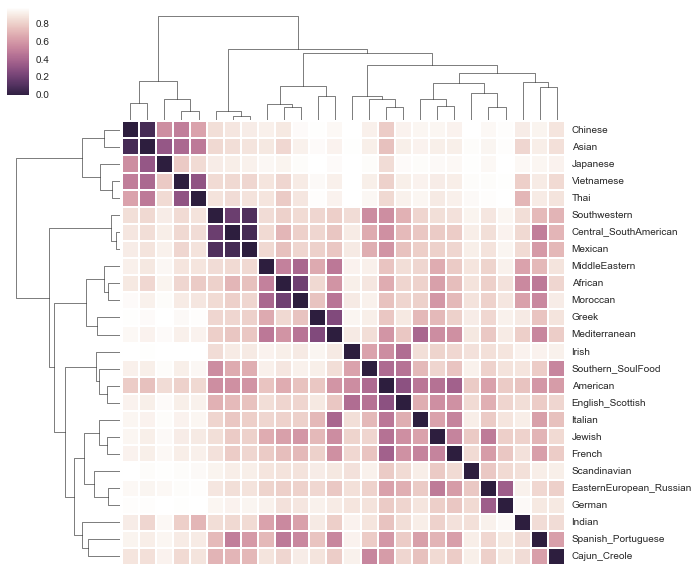

In [58]:
from numpy.random import RandomState
# Keep the columns that refer only to ingredients
column_names = set(epicurious_per_cuisine.columns.values.tolist())
column_names.remove('cuisine')
numerical = epicurious_per_cuisine.set_index('cuisine')
numerical = numerical[list(column_names)]
# Compute the similarity matrix between the different cuisines
distance_matrix = squareform(pdist(numerical.values, metric='cosine'))
# Read this matrix as a Dataframe, with the column names and the index 
# set to be the name of the cuisines.
similarities = pd.DataFrame(distance_matrix, 
                            columns=list(numerical.index), 
                            index=list(numerical.index))
cg = sns.clustermap(similarities, method="complete", figsize=(10,10), 
                    xticklabels=False, metric='cosine', col_cluster=True,
                    cmap=sns.cubehelix_palette(reverse=True, light=1, as_cmap=True))

In the above graphic, both the rows and the columns are the different cuisines in our datasets (with the same order). A dark square means that the corresponding pair of cuisines are quite similar (with the darkest colors being on the diagonal). We can definitely see a geographical clustering of the cuisines, with **east Asian** on top, followed by **south American**, the **Mediterranean**, the **Anglo-american** and the **European**.

### References

1. Ahn, Yong-Yeol, et al. "Flavor network and the principles of food pairing." Scientific reports 1 (2011).

In [18]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()